# Roadmap

The goal of this notebook is to provide an example of how to scrape NEXRAD level II data and use pyart and csu_radar_tools to calculate radar rainfall estimates at rain gage locations during a storm. Inspiration from the discussion [here](https://groups.google.com/forum/#!msg/pyart-users/dxw0Mm7-SzI/iRI3-yXxDQAJ)

  1. Genarate mock rain gage data
  2. Find available NEXRAD data
  2. Download NEXRAD data
  4. Mask bad data
  5. Download sounding data
  6. Classify hydrometeors
  7. Compute rainfall estimate
  8. Interpolate radially
  9. Pull out rainfall estimates at gage locations

Before getting started, set up your environment with all the necessities to run this notebook. To create this environment just run **`$ conda env create -f environment.yml`** where **`environment.yml`** is a file containing the following:

In [18]:
!cat environment.yml

name: radar
channels:
- conda-forge
- defaults
dependencies:
- python=2.7
- arm_pyart
- basemap
- basemap-data-hires
- matplotlib
- jupyter
- pandas
- numpy
- cython
- wget
- lxml
- pyproj
- pip:
  - skewt
  - git+git://github.com/CSU-Radarmet/CSU_RadarTools.git


## Mock rain gage data

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

In [3]:
ID='KTLH'
latitude = 30.39758301
longitude = -84.32894135

year=2016
month=9
day=2
hour=2

t_start = '2016-09-02 02:00'
t_end = '2016-09-02 04:00'

In [4]:
%%time

netcdf=True

gage_times = pd.date_range(pd.datetime(year, month, day, hour), freq='15min', periods=10, tz='UTC')
gage_locs = np.random.rand(50,2)*2+ np.array([latitude, longitude])
gage_data = np.zeros((gage_times.shape[0], gage_locs.shape[0]))
gage_names = ['G'+str(i) for i in range(1, gage_locs.shape[0]+1)]

gage_df_data = pd.DataFrame(index=gage_times, data=gage_data, columns=gage_names)
gage_df_locs = pd.DataFrame(index=gage_names, data=gage_locs, columns=['lat', 'lon'])

if not netcdf:
    gage_df = pd.concat([gage_df_locs, gage_df_data.T], axis=1)
    gage_df.head()

def to_da(i, name, gage_data, gage_times):
    return xr.DataArray(gage_data[:,i], name=name, dims={'time': gage_times.shape},
                        coords={'time': gage_times.astype('datetime64[ns]'), 'station':name})

datasets = [to_da(i, name, gage_data, gage_times) for i, name in enumerate(gage_names)]
combined = xr.concat(datasets, 'station')
ds0 = combined.to_dataset(name='rain_gage_accumulation')

gage_df_locs.index.name='station'
ds_gage = ds0.merge(xr.Dataset(gage_df_locs))
ds_gage.set_coords(['lat', 'lon'], inplace=True)
print(ds_gage)

<xarray.Dataset>
Dimensions:                 (station: 50, time: 10)
Coordinates:
  * time                    (time) datetime64[ns] 2016-09-02T02:00:00 ...
  * station                 (station) |S3 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' ...
    lat                     (station) float64 31.84 31.54 31.93 31.7 31.74 ...
    lon                     (station) float64 -84.19 -82.41 -82.68 -84.24 ...
Data variables:
    rain_gage_accumulation  (station, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
CPU times: user 24.6 ms, sys: 154 µs, total: 24.8 ms
Wall time: 42.2 ms


## Find Available Data

First we will see what data are available for the date and site that we are interested in. 

In [5]:
Y = '{Y:04d}'.format(Y=year)
M = '{M:02d}'.format(M=month)
D = '{D:02d}'.format(D=day)

url = 'http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id={ID}&yyyy={Y}&mm={M}&dd={D}&product=AAL2'.format(
       ID=ID, Y=Y, M=M, D=D)
print(url)

http://www.ncdc.noaa.gov/nexradinv/bdp-download.jsp?id=KTLH&yyyy=2016&mm=09&dd=02&product=AAL2


In [6]:
%%time
from lxml.html import parse
import re

page = parse(url)
pattern = re.compile("[A-Z]{4}([0-9]{8})_([0-9]{6})*")

data_urls = []
filenames = []
times = []

for el in page.xpath("//div[@class='bdpLink']"):
    data_url = el.find("a").get("href")
    filename = data_url.split('/')[-1]
    if not pattern.search(filename):
        continue
    time = pd.Timestamp(filename[4:19].replace('_', ' '))
    data_urls.append(data_url)
    filenames.append(filename)
    times.append(time)
times = pd.DatetimeIndex(times)

CPU times: user 24.1 ms, sys: 6.8 ms, total: 30.9 ms
Wall time: 1.16 s


In [7]:
t0 = times.asof(pd.Timestamp(t_start))
tn = times.asof(pd.Timestamp(t_end))

data_urls = data_urls[times.get_loc(t0): times.get_loc(tn)]
filenames = filenames[times.get_loc(t0): times.get_loc(tn)]

nscans = len(filenames)

## Download Data

Now that you have a valid data_url, all that is left is downloading the data.

In [8]:
%%time

def get_datafile(data_url, filename, cache='./tmp/'):
    import os
    import wget

    if not os.path.isdir(cache):
        os.mkdir(cache)

    if os.path.isfile(cache+filename):
        print('using cached file ...')
        path_to_file = cache+filename
    else:
        print('downloading file ...')
        path_to_file = wget.download(data_url, out=cache+filename)
    print(path_to_file)
    return path_to_file

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


In [9]:
%%time

if nscans > 100:
    print('Do you really intend to process >100 files?')
else:
    paths = []
    for data_url, filename in zip(data_urls, filenames):
        paths.append(get_datafile(data_url, filename))

using cached file ...
./tmp/KTLH20160902_015528_V06
using cached file ...
./tmp/KTLH20160902_020138_V06
using cached file ...
./tmp/KTLH20160902_020748_V06
using cached file ...
./tmp/KTLH20160902_021359_V06
using cached file ...
./tmp/KTLH20160902_022009_V06
using cached file ...
./tmp/KTLH20160902_022617_V06
using cached file ...
./tmp/KTLH20160902_023228_V06
using cached file ...
./tmp/KTLH20160902_023838_V06
using cached file ...
./tmp/KTLH20160902_024448_V06
using cached file ...
./tmp/KTLH20160902_025125_V06
using cached file ...
./tmp/KTLH20160902_025803_V06
using cached file ...
./tmp/KTLH20160902_030439_V06
using cached file ...
./tmp/KTLH20160902_031116_V06
using cached file ...
./tmp/KTLH20160902_031754_V06
using cached file ...
./tmp/KTLH20160902_032431_V06
using cached file ...
./tmp/KTLH20160902_033108_V06
using cached file ...
./tmp/KTLH20160902_033746_V06
using cached file ...
./tmp/KTLH20160902_034426_V06
using cached file ...
./tmp/KTLH20160902_035104_V06
CPU times: u

## Read data and calculate rainfall

In [10]:
import pyart
from skewt import SkewT

## Sounding

Optionally you can get data from a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html), and copy and paste it into a txt file. 

In [11]:
sounding = SkewT.Sounding('./tmp/sounding.txt')

In [12]:
fields = ['rain', 'r_kdp', 'r_z']
cols = ['gate_lon', 'gate_lat', 'gate_altitude']
cols.extend(fields)

## Run
First we need to import the tools from pyart_radar_tools, then we can process all the radar files

In [13]:
from pyart_radar_tools import *

def process_radar(path, sounding):
    radar = pyart.io.read(path)
    radar, start_gate, end_gate = mask_data(radar)
    dp_radar, vel_radar = separate_dp_vel_sweeps(radar)
    sw_vel_mask = construct_sw_vel_mask(vel_radar)
    radar = mask_dp_fiels(vel_radar, dp_radar, sw_vel_mask)
    radar = calculate_hidro_rain(radar, sounding)
    radar = calculate_rain_nexrad(radar)
    radar = calculate_rain_kdp(radar)
    for field in ['rain', 'r_kdp', 'r_z']:
        radar = interpolate_radially(radar, field, start_gate, end_gate,
                                     interpolate_max=10)
    return radar

In [14]:
%%time
radar0 = pyart.io.read(paths[0])
netcdf=True
gage_dict={}
for gage_name in gage_names:
    if netcdf:
        latitude = ds_gage.lat.sel(station=gage_name).values
        longitude = ds_gage.lon.sel(station=gage_name).values
    else:
        latitude = gage_df.loc[gage_name, 'lat']
        longitude = gage_df.loc[gage_name, 'lon']
    x_disp, y_disp = find_x_y_displacement(radar0, longitude, latitude)
    gage_dict.update({gage_name: {'x_disp': x_disp, 'y_disp': y_disp}})

sweep_times = []
sweep_stacks = []
for path in paths:
    print('processing', path)
    radar = process_radar(path, sounding)
    base_time = pd.Timestamp(radar.time['units'].split()[2])
    for sweep in range(radar.nsweeps):
        end_sweep_time = pd.Timedelta(seconds=radar.time['data'][radar.get_end(sweep)])+base_time
        gate_x, gate_y, gate_z = radar.get_gate_x_y_z(sweep)
        sweep_times.append(end_sweep_time)
        
        b = []
        for gage_name in gage_names:
            distances = np.sqrt((gate_x-gage_dict[gage_name]['x_disp'])**2. + 
                                (gate_y-gage_dict[gage_name]['y_disp'])**2.)
            ray, gate = np.unravel_index(distances.argmin(), distances.shape)

            a = np.array([radar.gate_latitude['data'][ray, gate],
                          radar.gate_longitude['data'][ray, gate],
                          radar.gate_altitude['data'][ray, gate]])
            a = np.concatenate([a, [radar.fields[field]['data'][ray, gate] for field in fields]])
            b.append(a)
        sweep_stacks.append(np.stack(b, axis=1))
c = np.stack(sweep_stacks, axis=2)

d = {'time': {'dims': ('time'), 'data': sweep_times},
     'station': {'dims': ('station'), 'data': gage_names}}
for i, name in enumerate(cols):
    d.update({name: {'dims': ('station', 'time'), 'data': c[i]}})
ds_radar = xr.Dataset.from_dict(d)
ds_radar.set_coords(['gate_altitude', 'gate_lat', 'gate_lon'], inplace=True)

('processing', './tmp/KTLH20160902_015528_V06')


/home/jsignell/miniconda2/envs/radar/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


('processing', './tmp/KTLH20160902_020138_V06')
('processing', './tmp/KTLH20160902_020748_V06')
('processing', './tmp/KTLH20160902_021359_V06')
('processing', './tmp/KTLH20160902_022009_V06')
('processing', './tmp/KTLH20160902_022617_V06')
('processing', './tmp/KTLH20160902_023228_V06')
('processing', './tmp/KTLH20160902_023838_V06')
('processing', './tmp/KTLH20160902_024448_V06')
('processing', './tmp/KTLH20160902_025125_V06')
('processing', './tmp/KTLH20160902_025803_V06')
('processing', './tmp/KTLH20160902_030439_V06')
('processing', './tmp/KTLH20160902_031116_V06')
('processing', './tmp/KTLH20160902_031754_V06')
('processing', './tmp/KTLH20160902_032431_V06')
('processing', './tmp/KTLH20160902_033108_V06')
('processing', './tmp/KTLH20160902_033746_V06')
('processing', './tmp/KTLH20160902_034426_V06')
('processing', './tmp/KTLH20160902_035104_V06')
CPU times: user 10min 3s, sys: 27.9 s, total: 10min 31s
Wall time: 10min 34s


In [15]:
%%time
ds_radar_15 = ds_radar[fields].resample('15min', 'time', label='right')

CPU times: user 12.4 ms, sys: 1.02 ms, total: 13.4 ms
Wall time: 130 ms


In [16]:
%%time
ds = ds_gage.merge(ds_radar_15)

CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 21.8 ms


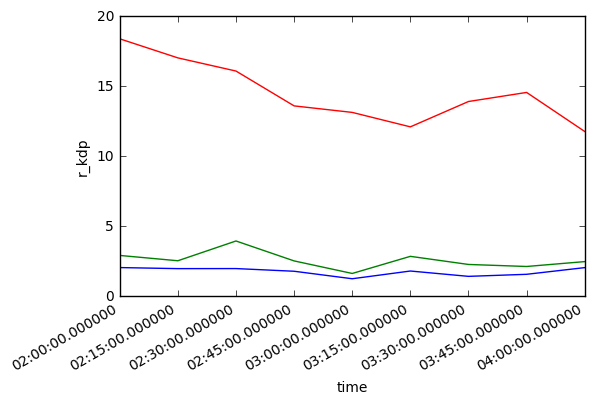

In [17]:
%matplotlib inline
ds.rain.mean('station').plot(c='g')
ds.r_z.mean('station').plot(c='b')
ds.r_kdp.mean('station').plot(c='r')